# 07 Milestone Project 1: 🍔👁 Food Vision Big™

We're going to be building Food Vision Big™, using all of the data from the Food101 dataset.

Yep. All 75,750 training images and 25,250 testing images.

This time **we've got the goal of beating [DeepFood](https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment)**, a 2016 paper which used a Convolutional Neural Network trained for 2-3 days to achieve **77.4% top-1 accuracy**.

> 🔑 **Note:** **Top-1 accuracy** means "accuracy for the top softmax activation value output by the model" (because softmax ouputs a value for every class, but top-1 means only the highest one is evaluated). **Top-5 accuracy** means "accuracy for the top 5 softmax activation values output by the model", in other words, did the true label appear in the top 5 activation values? Top-5 accuracy scores are usually noticeably higher than top-1.

|  | 🍔👁 Food Vision Big™ | 🍔👁 Food Vision mini |
|-----|-----|-----|
| Dataset source | TensorFlow Datasets | Preprocessed download from Kaggle | 
| Train data | 75,750 images | 7,575 images | 
| Test data | 25,250 images | 25,250 images | 
| Mixed precision | Yes | No |
| Data loading | Performanant tf.data API | TensorFlow pre-built function |  
| Target results | 77.4% top-1 accuracy (beat [DeepFood paper](https://arxiv.org/abs/1606.05675)) | 50.76% top-1 accuracy (beat [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf)) | 

*Table comparing difference between Food Vision Big (this notebook) versus Food Vision mini (previous notebook).*

Alongside attempting to beat the DeepFood paper, we're going to learn about two methods to significantly improve the speed of our model training:
1. Prefetching
2. Mixed precision training

But more on these later.

## What we're going to cover

* Using TensorFlow Datasets to download and explore data
* Creating preprocessing function for our data
* Batching & preparing datasets for modelling (**making our datasets run fast**)
* Creating modelling callbacks
* Setting up **mixed precision training**
* Building a feature extraction model (see [transfer learning part 1: feature extraction](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb))
* Fine-tuning the feature extraction model (see [transfer learning part 2: fine-tuning](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb))
* Viewing training results on TensorBoard


> 📖 **Resource:** See the full set of course materials on GitHub: https://github.com/mrdbourke/tensorflow-deep-learning

## Check GPU

We're going to be using **mixed precision training**.
<br>
Mixed precision training was introduced in [TensorFlow 2.4.0](https://blog.tensorflow.org/2020/12/whats-new-in-tensorflow-24.html).

<br>

What does **mixed precision training** do?
>Mixed precision training uses a combination of single precision (float32) and half-preicison (float16) data types to speed up model training (up 3x on modern GPUs).

We'll talk about this more later on but in the meantime you can read the [TensorFlow documentation on mixed precision](https://www.tensorflow.org/guide/mixed_precision) for more details.
<br>
For now, before we can move forward if we want to use mixed precision training, we need to make sure the GPU powering our Google Colab instance (if you're using Google Colab) is compataible. 
<br>
For mixed precision training to work, you need access to a GPU with a compute compability score of 7.0+. 

<br>

Google Colab offers P100, K80 and T4 GPUs, however, **the P100 and K80 aren't compatible with mixed precision training**.
<br>
Therefore before we proceed we need to make sure we have **access to a Tesla T4 GPU in our Google Colab instance**.

If you're not using Google Colab, you can find a list of various [Nvidia GPU compute capabilities on Nvidia's developer website](https://developer.nvidia.com/cuda-gpus#compute).

> 🔑 **Note:** If you run the cell below and see a P100 or K80, try going to to Runtime -> Factory Reset Runtime (note: this will remove any saved variables and data from your Colab instance) and then retry to get a T4.

In [ ]:
# !pip install tensorflow==2.4.1 # bug with EfficientNetBX and tf version 2.5+ see after

In [ ]:
# If using Google Colab, this should output "Tesla T4" otherwise, 
# you won't be able to use mixed precision training
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-40b0dd7f-85e2-081a-0d4a-f4eef98d12db)


In [ ]:
import random 
import zipfile
import datetime
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import tensorflow as tf

In [ ]:
# Check TensorFlow version (should be 2.4.0+)
print(tf.__version__)

2.9.2


In [ ]:
tf.config.list_physical_devices('GPU') # need GPU

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Get helper functions

We've created a series of helper functions throughout the previous notebooks in the course. Instead of rewriting them (tedious), we'll import the [`helper_functions.py`](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py) file from the GitHub repo.

In [ ]:
# Get helper functions file

if not Path("helper_functions.py").exists():
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")

--2022-12-05 08:51:31--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-12-05 08:51:31 (69.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys, unzip_data

## Use TensorFlow Datasets to Download Data

In previous notebooks, we've downloaded our food images (from the [Food101 dataset](https://www.kaggle.com/dansbecker/food-101/home)) from Google Storage.
<br>
And this is a typical workflow you'd use if you're working on your own datasets.

<br>

For many of the most popular datasets in the machine learning world (often referred to and used as benchmarks), you can access them through [TensorFlow Datasets (TFDS)](https://www.tensorflow.org/datasets/overview).

What is **TensorFlow Datasets**?
<br>
A place for prepared and ready-to-use machine learning datasets.

<br>

Why use TensorFlow Datasets?

* Load data already in Tensors
* Practice on well established datasets
* Experiment with differet data loading techniques (like we're going to use in this notebook)
* Experiment with new TensorFlow features quickly (such as mixed precision training)

Why *not* use TensorFlow Datasets?

* The datasets are static (they don't change, like your real-world datasets would)
* Might not be suited for your particular problem (but great for experimenting)

To begin using TensorFlow Datasets we can import it under the alias `tfds`.


In [ ]:
import tensorflow_datasets as tfds

In [ ]:
# List available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is the dataset we're after available?

True


Beautiful! It looks like the dataset we're after is available (note there are plenty more available but we're on Food101).
<br>
To get access to the Food101 dataset from the TFDS, we can use the [`tfds.load()`](https://www.tensorflow.org/datasets/api_docs/python/tfds/load) method.

<br>

In particular, we'll have to pass it a few parameters to let it know what we're after:
* `name` (str) : the target dataset (e.g. `"food101"`)
* `split` (list, optional) : what splits of the dataset we're after (e.g. `["train", "validation"]`)
  * the `split` parameter is quite tricky. See [the documentation for more](https://github.com/tensorflow/datasets/blob/master/docs/splits.md).
* `shuffle_files` (bool) : whether or not to shuffle the files on download, defaults to `False` 
* `as_supervised` (bool) : `True` to download data samples in tuple format (`(data, label)`) or `False` for dictionary format 
* `with_info` (bool) : `True` to download dataset metadata (labels, number of samples, etc)

> 🔑 **Note:** Calling the `tfds.load()` method will start to download a target dataset to disk if the `download=True` parameter is set (default). This dataset could be 100GB+, so make sure you have space.

In [ ]:
# Load in the data (takes about 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101", # target dataset to get from TFDS
                                             split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteG9QPJL/food101-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteG9QPJL/food101-validation.tfrecord*...:   0%|         …

Dataset food101 downloaded and prepared to ~/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


We've now got access to entire Food101 dataset (in tensor format) ready for modelling.
<br>
Now let's get a little information from our dataset, starting with the class names.

Getting class names from a TensorFlow_Datasets dataset requires downloading the "`dataset_info`" (e.g.`ds_info`) variable (by using the `as_supervised=True` parameter in the `tfds.load()` method. 
<br>
**note:** this will only work for supervised datasets in TFDS).

We can access the class names of a particular dataset using the `dataset_info.features` attribute and accessing `names` attribute of the the `"label"` key.

In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### Exploring the Food101 data from TensorFlow Datasets

Now we need to **Visualize** our data. 

Let's find out a few details about our dataset:
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels of our input data look like (e.g. one-hot encoded versus label-encoded)
* Do the labels match up with the class names?

To do, let's take one sample off the training data (using the [`.take()` method](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take)) and explore it. 

In [ ]:
# Take one sample off the training data
train_one_sample = train_data.take(1) # sample format is (image_tensor, label)
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
for image, label in train_one_sample:
    print(f"""
    Image shape : {image.shape}
    Image type : {image.dtype}
    Label : (label-encode) {label}
    Classe name : {class_names[label.numpy()]} 
    """)


    Image shape : (512, 512, 3)
    Image type : <dtype: 'uint8'>
    Label : (label-encode) 18
    Classe name : chicken_curry 
    


In [ ]:
# What are the min and max values?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=5>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

Alright looks like our image tensors have values of between 0 & 255 (RGB) and the values are of data type `unit8`.

We might have to preprocess these before passing them to a neural network. But we'll handle this later.

Label are encode in a *label-encode format*

<br>

In the meantime, let's see if we can plot an image sample.

### Plot an image from TensorFlow Datasets

We've seen our image tensors in tensor format, now let's really adhere to our motto.

"Visualize, visualize, visualize!"

Let's plot one of the image samples using [`matplotlib.pyplot.imshow()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) and set the title to target class name.

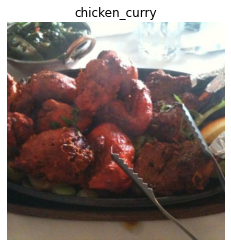

In [ ]:
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## Create preprocessing functions for our data

In previous notebooks, when our images were in folder format we used the method [`tf.keras.utils.image_dataset_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) to load them in.

**Doing this meant our data was loaded into a format ready to be used with our models.**

**However, since we've downloaded the data from TensorFlow Datasets, there are a couple of preprocessing steps we have to take before it's ready to model.** 

More specifically, our data is currently:

* In `uint8` data type
* Comprised of all differnet sized tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

Whereas, models like data to be:

* In `float32` data type
* Have all of the same size tensors (batches require all tensors have the same shape, e.g. `(224, 224, 3)`)
* Scaled (values between 0 & 1), also called normalized

To take care of these, we'll create a `preprocess_img()` function which:

* Resizes an input image tensor to a specified size using [`tf.image.resize()`](https://www.tensorflow.org/api_docs/python/tf/image/resize)
* Converts an input image tensor's current datatype to `tf.float32` using [`tf.cast()`](https://www.tensorflow.org/api_docs/python/tf/cast)

> 🔑 **Note:** Pretrained EfficientNetBX models in [`tf.keras.applications.efficientnet`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet) (what we're going to be using) **have rescaling built-in**. But for many other model architectures you'll want to rescale your data (e.g. get its values between 0 & 1). This could be incorporated inside your "`preprocess_img()`" function (like the one below) or within your model as a [`tf.keras.layers.Rescaling`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling) layer.

In [ ]:
def preprocess_img(image, label, im_size=224):
    image = tf.image.resize(image, (im_size, im_size))
    image = tf.cast(image, tf.float32)
    return image, label

In [ ]:
preprocessed_im = preprocess_img(image, label)[0]
print(f"""
    Image shape : {image.shape} --- Preprocessed image shape : {preprocessed_im.shape}
    Image type : {image.dtype} --- Preprocessed image type : {preprocessed_im.dtype}
    """)


    Image shape : (512, 512, 3) --- Preprocessed image shape : (224, 224, 3)
    Image type : <dtype: 'uint8'> --- Preprocessed image type : <dtype: 'float32'>
    


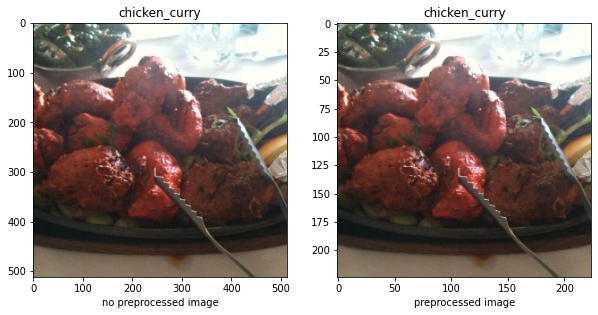

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(image/255)
plt.title(class_names[label.numpy()])
plt.xlabel("no preprocessed image")

plt.subplot(1,2,2)
plt.imshow(preprocessed_im/255)
plt.title(class_names[label.numpy()])
plt.xlabel("preprocessed image");

## Batch & prepare datasets

**Computing on batches is memory efficient**.

We turn our data from 101,000 image tensors and labels (train and test combined) into batches of 32 image and label pairs, thus enabling it to fit into the memory of our GPU.

To do this in effective way, we're going to be leveraging a number of methods from the [`tf.data` API](https://www.tensorflow.org/api_docs/python/tf/data).

> 📖 **Resource:** For loading data in the most performant way possible, see the TensorFlow documentation on [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance).

Specifically, we're going to be using:

* [`map()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) - maps a predefined function to a target dataset (e.g. `preprocess_img()` to our image tensors)
* [`shuffle()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle) - randomly shuffles the elements of a target dataset up `buffer_size` (ideally, the `buffer_size` is equal to the size of the dataset, however, this may have implications on memory)
* [`batch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) - turns elements of a target dataset into batches (size defined by parameter `batch_size`)
* [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) - prepares subsequent batches of data whilst other batches of data are being computed on (improves data loading speed but costs memory)
* Extra: [`cache()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) - caches (saves them for later) elements in a target dataset, saving loading time (will only work if your dataset is small enough to fit in memory, standard Colab instances only have 12GB of memory) 

Things to note:
- Can't batch tensors of different shapes (e.g. different image sizes, need to reshape images first, hence our `preprocess_img()` function)
- `shuffle()` keeps a buffer of the number you pass it images shuffled, ideally this number would be all of the samples in your training set, however, if your training set is large, this buffer might not fit in memory (a fairly large number like 1000 or 10000 is usually suffice for shuffling)
- For methods with the `num_parallel_calls` parameter available (such as `map()`), setting it to`num_parallel_calls=tf.data.AUTOTUNE` will parallelize preprocessing and significantly improve speed
- Can't use `cache()` unless your dataset can fit in memory

Woah, the above is alot. But once we've coded below, it'll start to make sense.

We're going to through things in the following order:

```
Original dataset (e.g. train_data) -> map() -> shuffle() -> batch() -> prefetch() -> PrefetchDataset
```

This is like saying, 

> "Hey, map this preprocessing function across our training dataset, then shuffle a number of elements before batching them together and make sure you prepare new batches (prefetch) whilst the model is looking through the current batch".

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/07-prefetching-from-hands-on-ml.png)

*What happens when you use prefetching (faster) versus what happens when you don't use prefetching (slower). **Source:** Page 422 of [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow Book by Aurélien Géron](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/).*


In [ ]:
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE) # useless to shuffle test data

In [ ]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create modelling callbacks

Since we're going to be training on a large amount of data and training could take a long time, it's a good idea to set up some modelling callbacks so we be sure of things like our model's training logs being tracked and our model being checkpointed (saved) after various training milestones.

To do each of these we'll use the following callbacks:
* [`tf.keras.callbacks.TensorBoard()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard) - allows us to keep track of our model's training history so we can inspect it later (**note:** we've created this callback before have imported it from `helper_functions.py` as `create_tensorboard_callback()`)
* [`tf.keras.callbacks.ModelCheckpoint()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) - saves our model's progress at various intervals so we can load it and resuse it later without having to retrain it
  * Checkpointing is also helpful so we can start fine-tuning our model at a particular epoch and revert back to a previous state if fine-tuning offers no benefits

In [ ]:
tensorboard = create_tensorboard_callback('training_logs', "101_classes_all_data_feature_extract")

checkpoint_path = Path.cwd() / "model_checkpoints/cp.ckpt"
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                monitor="val_accuracy", # save the model weights with best validation accuracy
                                                save_best_only=True, # only save the best weights
                                                save_weights_only=True, # only save model weights (not whole model)
                                                verbose=0)

Saving TensorBoard log files to: training_logs/101_classes_all_data_feature_extract/20221205-090044


## Setup mixed precision training

Normally, tensors in TensorFlow default to the float32 datatype (unless otherwise specified).

In computer science, float32 is also known as [single-precision floating-point format](https://en.wikipedia.org/wiki/Single-precision_floating-point_format). The 32 means it usually occupies 32 bits in computer memory.
<br>
Your GPU has a limited memory, therefore it can only handle a number of float32 tensors at the same time.

This is where mixed precision training comes in.
<br>
Mixed precision training involves using a mix of float16 and float32 tensors to make better use of your GPU's memory.

<br>

Well, if you thought since float32 meant single-precision floating-point, you might've guessed float16 means [half-precision floating-point format](https://en.wikipedia.org/wiki/Half-precision_floating-point_format).
<br>
For tensors in float16 format, each element occupies 16 bits in computer memory.

<br>

So, where does this leave us?

As mentioned before, when using mixed precision training, your model will make use of float32 and float16 data types to use less memory where possible and in turn run faster (using less memory per tensor means more tensors can be computed on simultaneously).

As a result, using mixed precision training can improve your performance on modern GPUs (those with a compute capability score of 7.0+) by up to 3x.

For a more detailed explanation, I encourage you to read through the [TensorFlow mixed precision guide](https://www.tensorflow.org/guide/mixed_precision) (I'd highly recommend at least checking out the summary).
<br>
And [Tensorflow mixed precision guie using colab](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/mixed_precision.ipynb)

<br>

---
<br>

> 📖 **Resource:** If you'd like to learn more about precision in computer science (the detail to which a numerical quantity is expressed by a computer), see the [Wikipedia page](https://en.wikipedia.org/wiki/Precision_(computer_science)) (and accompanying resources). 

<br>

The beautiful thing is, the [`tensorflow.keras.mixed_precision`](https://www.tensorflow.org/api_docs/python/tf/keras/mixed_precision/) API has made it very easy for us to get started.

First, we'll import the API and then use the [`set_global_policy()`](https://www.tensorflow.org/api_docs/python/tf/keras/mixed_precision/set_global_policy) method to set the *dtype policy* to `"mixed_float16"`.


In [ ]:
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
# For short, you can directly pass a string to set_global_policy, which is typically done in practice.
# mixed_precision.set_global_policy('mixed_float16')

# For TPUs, the mixed_bfloat16 policy should be used instead.

Nice! As long as the GPU you're using has a compute capability of 7.0+ the cell above should run without error.

Now we can check the global dtype policy (the policy which will be used by layers in our model) using the [`mixed_precision.global_policy()`](https://www.tensorflow.org/api_docs/python/tf/keras/mixed_precision/global_policy) method.

In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

In [ ]:
print(f'Compute dtype: {policy.compute_dtype}')
print(f'Variable dtype: {policy.variable_dtype}')

Compute dtype: float16
Variable dtype: float32


In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-40b0dd7f-85e2-081a-0d4a-f4eef98d12db)


In [ ]:
tf.config.list_physical_devices("GPU") # need GPU

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Build feature extraction model

* Callbacks: ready to roll.
* Mixed precision: turned on.

<br>

Let's build a model.

Because our dataset is quite large, we're going to move towards fine-tuning an existing pretrained model (EfficienetNetB0).
<br>
But before we get into fine-tuning, let's set up a feature-extraction model.

Recall, the typical order for using transfer learning is:

1. Build a feature extraction model (replace the top few layers of a pretrained model) 
2. Train for a few epochs with lower layers frozen
3. Fine-tune if necessary with multiple layers unfrozen

<br>

To build the feature extraction model , we'll:
* Use `EfficientNetB0` from [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications) pre-trained on ImageNet as our base model
  * We'll download this without the top layers using `include_top=False` parameter so we can create our own output layers
* Freeze the base model layers so we can use the pre-learned patterns the base model has found on ImageNet
* Put together the input, base model, pooling and output layers in a [Functional model](https://keras.io/guides/functional_api/)
* Compile the Functional model using the Adam optimizer and [sparse categorical crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy) as the loss function (**since our labels aren't one-hot encoded**)
* Fit the model for 3 epochs using the TensorBoard and ModelCheckpoint callbacks

> 🔑 **Note:** Since we're using mixed precision training, our model needs a separate output layer with a hard-coded `dtype=float32`, (e.g.`layers.Activation("softmax", dtype=tf.float32)`). This ensures the outputs of our model are returned back to the float32 data type which is more numerically stable than the float16 datatype (important for loss calculations). 
<br><br>
A softmax activation at the end of the model should be float32. Because the dtype policy is mixed_float16, the softmax activation would normally have a float16 compute dtype and output float16 tensors.
This can be fixed by separating the Dense and softmax layers, and by passing dtype='float32' to the softmax layer:

See the ["Building the model"](https://www.tensorflow.org/guide/mixed_precision#building_the_model) section in the TensorFlow mixed precision guide for more.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/07-mixed-precision-code-before-and-after.png)
*Turning mixed precision on in TensorFlow with 3 lines of code.*

---

You may face an error if you're using TensorFlow 2.5+ :
<br>
The error happens when you turn on mixed precision training for EfficientNetBX models ([error track on github](https://github.com/tensorflow/tensorflow/issues/49725))

<br>

**How to fix it ?**
<br>
The current workaround is to downgrade to TensorFlow 2.4.1 (the last version before 2.5)

```
!pip install tensorflow==2.4.1
```
After doing so, you'll have to restart your runtime (Runtime -> Restart runtime) to ensure TensorFlow 2.4.1 is active

---

**However we gonna use `ResNet` as base_model because error still happen with `EfficientNet`**

In [ ]:
tf.random.set_seed(0)

base_model = tf.keras.applications.ResNet101V2(include_top=False)
base_model.trainable = False

inputs = tf.keras.Input(shape=(224,224,3), name="input_layer")

# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below

x = tf.keras.layers.Rescaling(1./255)(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = tf.keras.layers.Dense(len(class_names))(x)

outputs = tf.keras.layers.Activation("softmax", dtype=tf.float32)(x)

model = tf.keras.Model(inputs, outputs)

model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer="adam",
              metrics=["acc"])

171317808/171317808 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 resnet101v2 (Functional)    (None, None, None, 2048)  42626560  
                                                                 
 pooling_layer (GlobalAverag  (None, 2048)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               206949    
                                                                 
 activation (Activation)     (None, 101)               0         
                                                             

## Checking layer dtype policies (are we using mixed precision?)

Before we said the mixed precision API will automatically change our layers dtype policy's to whatever the global dtype policy is (in our case it's `"mixed_float16"`).

We can check this by iterating through our model's layers and printing layer attributes such as `dtype` and `dtype_policy`.

In [ ]:
for layer in model.layers :
    print(f"{layer.name:-<20} Trainable:{layer.trainable} -- {layer.dtype} -- {layer.dtype_policy}  ")

input_layer--------- Trainable:True -- float32 -- <Policy "float32">  
rescaling----------- Trainable:True -- float32 -- <Policy "mixed_float16">  
resnet101v2--------- Trainable:False -- float32 -- <Policy "mixed_float16">  
pooling_layer------- Trainable:True -- float32 -- <Policy "mixed_float16">  
dense--------------- Trainable:True -- float32 -- <Policy "mixed_float16">  
activation---------- Trainable:True -- float32 -- <Policy "float32">  


Going through the above we see:
* `layer.name` (str) : a layer's human-readable name, can be defined by the `name` parameter on construction
* `layer.trainable` (bool) : whether or not a layer is trainable
* `layer.dtype` : the data type a layer stores its variables in
* `layer.dtype_policy` : the data type a layer computes in

> 🔑 **Note:** A layer can have a dtype of `float32` and a dtype policy of `"mixed_float16"` because it stores its variables (weights & biases) in `float32` (more numerically stable), however it computes in `float16` (faster).

We can also check the same details for our model's base model.


In [ ]:
for layer in base_model.layers[:10] :
    print(f"{layer.name:-<30} Trainable:{layer.trainable} -- {layer.dtype} -- {layer.dtype_policy}  ")

input_1----------------------- Trainable:False -- float32 -- <Policy "float32">  
conv1_pad--------------------- Trainable:False -- float32 -- <Policy "mixed_float16">  
conv1_conv-------------------- Trainable:False -- float32 -- <Policy "mixed_float16">  
pool1_pad--------------------- Trainable:False -- float32 -- <Policy "mixed_float16">  
pool1_pool-------------------- Trainable:False -- float32 -- <Policy "mixed_float16">  
conv2_block1_preact_bn-------- Trainable:False -- float32 -- <Policy "mixed_float16">  
conv2_block1_preact_relu------ Trainable:False -- float32 -- <Policy "mixed_float16">  
conv2_block1_1_conv----------- Trainable:False -- float32 -- <Policy "mixed_float16">  
conv2_block1_1_bn------------- Trainable:False -- float32 -- <Policy "mixed_float16">  
conv2_block1_1_relu----------- Trainable:False -- float32 -- <Policy "mixed_float16">  


## Fit the feature extraction model

Three epochs should be enough for our top layers to adjust their weights enough to our food image data.

To save time per epoch, we'll also only validate on 10% of the test data.

In [ ]:
tf.get_logger().setLevel('ERROR')

history_feature_extraction = model.fit(train_data,
                                       epochs=3,
                                       steps_per_epoch=len(train_data),
                                       validation_data=test_data,
                                       validation_steps = int(0.1*len(test_data)),
                                       callbacks=[tensorboard, checkpoint]
                                       )

Epoch 1/3
2368/2368 [==============================] - 210s 82ms/step - loss: 2.2280 - acc: 0.4662 - val_loss: 1.7135 - val_acc: 0.5680
Epoch 2/3
2368/2368 [==============================] - 212s 89ms/step - loss: 1.6586 - acc: 0.5835 - val_loss: 1.5895 - val_acc: 0.5930
Epoch 3/3
2368/2368 [==============================] - 191s 80ms/step - loss: 1.4468 - acc: 0.6248 - val_loss: 1.6416 - val_acc: 0.5827


In [ ]:
score_feature_extraction = model.evaluate(test_data)
score_feature_extraction_train = model.evaluate(train_data)

2368/2368 [==============================] - 176s 73ms/step - loss: 1.1474 - acc: 0.6897


## Load and evaluate checkpoint weights

We can load in and evaluate our model's checkpoints by:

1. Cloning our model using [`tf.keras.models.clone_model()`](https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model) to make a copy of our feature extraction model with reset weights.
2. Calling the `load_weights()` method on our cloned model passing it the path to where our checkpointed weights are stored.
3. Calling `evaluate()` on the cloned model with loaded weights.

A reminder, checkpoints are helpful for when you perform an experiment such as fine-tuning your model. In the case you fine-tune your feature extraction model and find it doesn't offer any improvements, you can always revert back to the checkpointed version of your model.

In [ ]:
cloned_model = tf.keras.models.clone_model(model)
cloned_model.load_weights(checkpoint_path)

NotFoundError: ignored

**Each time you make a change to your model (including loading weights), you have to recompile.**

In [ ]:
# Compile cloned_model (with same parameters as original model)
cloned_model.compile(loss="sparse_categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

# Comparison : with and without mixed precision

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/07-mixed-precision-code-before-and-after.png)

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("float32")

In [ ]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

unzip_data("10_food_classes_10_percent.zip")

--2022-12-05 09:44:43--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 74.125.135.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   133MB/s    in 1.2s    

2022-12-05 09:44:45 (133 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
train_dir_10_percent = Path().cwd() / "10_food_classes_10_percent" / "train"
test_dir_10_percent = Path().cwd() / "10_food_classes_10_percent" / "test"

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_set_10_percent = image_dataset_from_directory(train_dir_10_percent, label_mode="categorical", image_size=(224,224)) 
test_set_10_percent = image_dataset_from_directory(test_dir_10_percent, label_mode="categorical", image_size=(224,224)) 

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
class_names_10_percent = train_set_10_percent.class_names
lenght = len(class_names_10_percent)

In [ ]:
tf.random.set_seed(0)

base_model = tf.keras.applications.ResNet101V2(include_top=False)
base_model.trainable = False

inputs = tf.keras.Input((224, 224, 3))

x = tf.keras.layers.Rescaling(1./255)(inputs)
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

outputs = tf.keras.layers.Dense(lenght, activation="softmax")(x)

model_without_mixed_precision = tf.keras.Model(inputs, outputs)
model_without_mixed_precision.compile(loss="categorical_crossentropy",
                                      optimizer="adam",
                                      metrics=["acc"])

In [ ]:
history_without_mixed_precision = model_without_mixed_precision.fit(train_set_10_percent,
                                                                    epochs = 5,
                                                                    validation_data = test_set_10_percent)

Epoch 1/5
24/24 [==============================] - 24s 771ms/step - loss: 1.9628 - acc: 0.3480 - val_loss: 1.1223 - val_acc: 0.6440
Epoch 2/5
24/24 [==============================] - 17s 724ms/step - loss: 0.8369 - acc: 0.7467 - val_loss: 0.8412 - val_acc: 0.7160
Epoch 3/5
24/24 [==============================] - 17s 702ms/step - loss: 0.5621 - acc: 0.8400 - val_loss: 0.7426 - val_acc: 0.7572
Epoch 4/5
24/24 [==============================] - 17s 699ms/step - loss: 0.4168 - acc: 0.8960 - val_loss: 0.7160 - val_acc: 0.7620
Epoch 5/5
24/24 [==============================] - 17s 702ms/step - loss: 0.3326 - acc: 0.9347 - val_loss: 0.6948 - val_acc: 0.7660


In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

tf.random.set_seed(0)

base_model = tf.keras.applications.ResNet101V2(include_top=False)
base_model.trainable = False

inputs = tf.keras.Input((224, 224, 3))

x = tf.keras.layers.Rescaling(1./255)(inputs)
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(lenght)(x)

outputs = tf.keras.layers.Activation("softmax", dtype=tf.float32)(x)

model_with_mixed_precision = tf.keras.Model(inputs, outputs)
model_with_mixed_precision.compile(loss="categorical_crossentropy",
                                   optimizer="adam",
                                   metrics=["acc"])

In [ ]:
history_without_mixed_precision = model_without_mixed_precision.fit(train_set_10_percent,
                                                                    epochs = 5,
                                                                    validation_data = test_set_10_percent)

Epoch 1/5
24/24 [==============================] - 18s 724ms/step - loss: 0.2687 - acc: 0.9560 - val_loss: 0.6755 - val_acc: 0.7788
Epoch 2/5
24/24 [==============================] - 18s 731ms/step - loss: 0.2208 - acc: 0.9693 - val_loss: 0.6657 - val_acc: 0.7740
Epoch 3/5
24/24 [==============================] - 17s 713ms/step - loss: 0.1844 - acc: 0.9787 - val_loss: 0.6613 - val_acc: 0.7800
Epoch 4/5
24/24 [==============================] - 17s 701ms/step - loss: 0.1583 - acc: 0.9920 - val_loss: 0.6639 - val_acc: 0.7852
Epoch 5/5
24/24 [==============================] - 17s 699ms/step - loss: 0.1363 - acc: 0.9907 - val_loss: 0.6481 - val_acc: 0.7872
